### Importing packages

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import os, glob
from skimage import filters
import momia2 as mo
from microfilm.microplot import microshow
import seaborn as sns

### Function for generating thumbnails

In [2]:
def thumbnails(patch,
               output_folder = '',
               img_id='0',
               fig_size=(4,4),
               channels = ['FITC','Phase_Ian'],
               scale_bar_length=5,
               channel_range = [[500,3000],[2000,20000]],
               cmaps=['pure_green','gist_gray'],
               distance_threshold=120,
               min_neighbor_count = 4,
               max_neighbor_count = 10):
    from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
    # calculate centroids
    centroids = []
    for x1,y1,x2,y2 in patch.regionprops[['$opt-x1','$opt-y1','$opt-x2','$opt-y2']].values:
        centroids.append([(x1+x2)/2,(y1+y2)/2])
    centroids = np.array(centroids)

    # cluster ROIs
    min_neighbor_count = min_neighbor_count
    max_neighbor_count = max_neighbor_count
    cluster = AgglomerativeClustering(n_clusters=None,
                                      distance_threshold=distance_threshold,linkage='complete').fit_predict(centroids)

    # get candidate ROI clusters
    candidates = []
    for i in np.unique(cluster):
        if np.sum(cluster==i) in range(min_neighbor_count,max_neighbor_count):
            candidates.append(i)
    # make plots 
    
    for c in candidates:
        try:
            xc,yc = centroids[cluster==c].T
            cluster_x,cluster_y = int(xc.mean()),int(yc.mean())
            cx1,cx2 = cluster_x-distance_threshold, cluster_x+distance_threshold
            cy1,cy2 = cluster_y-distance_threshold, cluster_y+distance_threshold
            stack = [patch.get_channel_data(channel)[cx1:cx2,cy1:cy2] for channel in channels]
            if stack[0].shape[0] == distance_threshold*2 and stack[0].shape[1] == distance_threshold*2:
                fig=plt.figure(figsize=fig_size)
                ax=fig.add_subplot()
                x=microshow(images=stack, fig_scaling=5,
                            cmaps=cmaps,
                            limits=channel_range,
                            unit='um', 
                            scalebar_size_in_units=scale_bar_length, 
                            scalebar_unit_per_pix=0.065, 
                            scalebar_font_size=None,
                            label_font_size=None,ax=ax)  
                plt.savefig(output_folder+'{}_cluster_{}.png'.format(img_id,c),dpi=300,bbox_inches='tight')
                plt.close()
        except:
            plt.close()
            continue

### sort file paths to a dictionary

In [3]:
pickle_dict = {}
for f in sorted(glob.glob('/Volumes/ExtremePro/BacProtac_analysis/20231018_microscopy_analysis/*.pk')):
    s,_r = f.split('/')[-1].split('RAPA')
    s = s[:-1]
    rapa = _r[0]
    header = _r.split('.')[0].split('_')[1]
    if s not in pickle_dict:
        pickle_dict[s] = [f]
    else:
        pickle_dict[s].append(f)

ValueError: not enough values to unpack (expected 2, got 1)

### Generating thumbnails

In [21]:
for k,v in pickle_dict.items():
    dst = '/Volumes/ExtremePro/BacProtac_analysis/20231025_thumbnail_240pix/{}/'.format(k)
    if not os.path.isdir(dst):
        os.mkdir(dst)
    
    # est dynamic range
    cells = []
    for f in v:
        if 'RAPA-' in f:
            p = mo.momia_IO.pickle_load(f)
            cells.append(p.regionprops)
    cells = pd.concat(cells)
    min_v = 250
    max_v = max(np.median(cells['FITC_max'].values)+200, 580)
    if 'EttA' in k:
        max_v += 300 #to account for oversaturation
    if 'HupB' in k:
        max_v -= 50 #to account for low signal
        
    rapa_plus = []
    rapa_minus = []
    n=0
    for i,f in enumerate(v):
        if 'RAPA+' in f:
            scale_bar_length=5
        else:
            scale_bar_length=0
        n+=1
        p = mo.momia_IO.pickle_load(f)
        img_id = '{}_{}'.format(f.split('/')[-1].split('.')[0],n)
        try:
            thumbnails(p,
                       output_folder = dst,
                       img_id=img_id,
                       fig_size=(4,4),
                       channels = ['FITC','Phase_Ian'],
                       scale_bar_length=scale_bar_length,
                       channel_range = [[min_v,max_v],[2000,50000]],
                       cmaps=['pure_green','gist_gray'],
                       min_neighbor_count=1,
                       distance_threshold=120)
        except:
            print(k)

Well_F05
Well_F05


### Get stats from image analysis

In [7]:
drange = []

for k,v in pickle_dict.items():
    dst = '/Volumes/ExtremePro/BacProtac_analysis/20231025_thumbnail_240pix/{}/'.format(k)
    if not os.path.isdir(dst):
        os.mkdir(dst)
    # est dynamic range
    cells = []
    for f in v:
        if 'RAPA-' in f:
            p = mo.momia_IO.pickle_load(f)
            cells.append(p.regionprops)
    cells = pd.concat(cells)
    min_v = 250
    max_v = max(np.median(cells['FITC_max'].values)+200, 580)
    if 'EttA' in k:
        max_v += 300
    if 'HupB' in k:
        max_v -= 50

    rapa_plus = []
    rapa_minus = []
    for i,f in enumerate(v):
        p = mo.momia_IO.pickle_load(f)
        p.filter_particles(filter_dict={'length [µm]': (3,10),
                  'aspect_ratio': (0.05, 0.9),
                  'solidity': (0.75, 1),
                  'eccentricity': (0.1, 1)})
        try:
            if 'RAPA+' in f:
                scale_bar_length=5
                rapa_plus.append(p.regionprops)
            else:
                scale_bar_length=0
                rapa_minus.append(p.regionprops)
        except:
            print(f)

    fitc_mean = 0
    fitc_std = 0
    if len(rapa_plus)>0:
        rapa_plus=pd.concat(rapa_plus)
        vals = rapa_plus['FITC_mean'].values
        mean = vals.mean()
        std = vals.std()
        z = (vals-mean)/std
        filtered = rapa_plus[(np.abs(z)<3)&(rapa_plus['$include']==1)]
        fitc_mean = filtered['FITC_mean'].mean()
        fitc_std = filtered['FITC_mean'].std()
    drange.append([k,'+',min_v,max_v,fitc_mean,fitc_std])

    fitc_mean = 0
    fitc_std = 0
    if len(rapa_minus)>0:
        rapa_minus=pd.concat(rapa_minus)
        vals = rapa_minus['FITC_mean'].values
        mean = vals.mean()
        std = vals.std()
        z = (vals-mean)/std
        filtered = rapa_minus[(np.abs(z)<3)&(rapa_minus['$include']==1)]
        fitc_mean = filtered['FITC_mean'].median()
        fitc_std = filtered['FITC_mean'].std()
    drange.append([k,'-',min_v,max_v,fitc_mean,fitc_std])
drange_df = pd.DataFrame(drange,columns=['Header','RAPA','Min','Max','FITC_mean','FITC_std'])
drange_df.to_csv('/Volumes/ExtremePro/BacProtac_analysis/20231025_thumbnail_240pix/drange_full_plate5.csv')

In [ ]:
drange_df=pd.read_csv('/Volumes/ExtremePro/BacProtac_analysis/20231025_thumbnail_240pix/drange_full_plate5.csv')

### Load reference sheets and data sheet

In [9]:
ref = pd.read_excel('./Important_References/Flow_well_keys_pub.xlsx')
flow_grouped = pd.read_csv('/Volumes/ExtremePro/BacProtac_analysis/grouped_median_20231025.csv')
#Imaging data were acquired at T=9 after RAPA treatment
t9 = flow_grouped[flow_grouped['Time numeric']==9]
#Import the degradation stat
deg = pd.read_excel('./Important_References/Deg_stats_final_pub.xlsx')
drange_df = pd.read_csv('/Volumes/ExtremePro/BacProtac_analysis/20231025_thumbnail_240pix/drange_full.csv')
ref['Well'] = [x[0]+x[1:].zfill(2) if isinstance(x,str) else x for x in ref['Sample'].values]
drange_df['Well'] = ['None' if 'Well' not in x else x.split('_')[1] for x in drange_df['Header'].values]

In [10]:
locus_list = []
target_list = []
rec_list = []
flow_fl = []
for header,w,rapa in drange_df[['Header','Well','RAPA']].values:
    # retrieve gene annotation by their well coordinates
    rec = '-'
    if w in ref['Well'].values:
        locus = np.unique(ref[ref['Well']==w]['Locus_tag'].values)[0]
        target = np.unique(ref[ref['Well']==w]['Target_gene'].values)[0]
    else:
        if 'REC' in header:
            rec = '+'
            target = header.split('_')[1]
        else:
            target = header
        if target in ref['Target_gene'].values:
            locus = np.unique(ref[ref['Target_gene']==target]['Locus_tag'].values)[0]
        else:
            target = target[0].lower() + target[1:]
            if target in ref['Target_gene'].values:
                locus = np.unique(ref[ref['Target_gene']==target]['Locus_tag'].values)[0]
            else:
                locus = '-'
    locus_list.append(locus)
    target_list.append(target)
    rec_list.append(rec)
    subset = t9[(t9['Locus']==locus)&(t9['Rapa']==rapa)]
    if len(subset)>0:
        flow_fl.append(subset['AlexaFluor488-H'].values[:2].mean())
    else:
        flow_fl.append(0)
drange_df['Locus'] = locus_list
drange_df['Target_gene'] = target_list
drange_df['Rec'] = rec_list
drange_df['Flow_intensity'] = flow_fl
drange_df['Microscopy_intensity (log2-transformed)'] = np.log2(drange_df['FITC_mean'].values+1)

### Plot flow-microscopy correlation

In [14]:
val_list = []
for x in drange_df['Locus'].values:
    if x in ref[ref['Plate']=='Plate5']['Locus_tag'].unique():
        val_list.append(1)
    else:
        val_list.append(0)
drange_df['as_validation'] = val_list

/var/folders/1y/_2nhqmfd56s2k1hktst6p9b80000gn/T/ipykernel_9696/1750996898.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(data=subset[(drange_df['RAPA']=='+')],x='Flow_intensity',y='Microscopy_intensity (log2-transformed)',color=rapa_color,ax=ax)
/var/folders/1y/_2nhqmfd56s2k1hktst6p9b80000gn/T/ipykernel_9696/1750996898.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(x) for x in ax.get_xticks()],fontname='Arial',fontsize=12)
/var/folders/1y/_2nhqmfd56s2k1hktst6p9b80000gn/T/ipykernel_9696/1750996898.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([round(x,1) for x in ax.get_yticks()],fontname='Arial',fontsize=12)


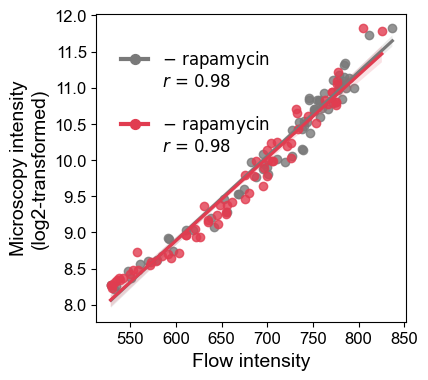

In [19]:
from scipy.stats import pearsonr
ctrl_color=np.array([121,121,121])/255
rapa_color=np.array([225,60,80])/255

fig=plt.figure(figsize=(4,4))
ax = fig.add_subplot()
subset = drange_df[(drange_df['Flow_intensity']>0)&\
                    (drange_df['Rec']=='-')&\
                    (drange_df['as_validation']==0)&\
                    (drange_df['Microscopy_intensity (log2-transformed)']>5)].copy()

sns.regplot(data=subset[(subset['RAPA']=='-')],x='Flow_intensity',y='Microscopy_intensity (log2-transformed)',color=ctrl_color,ax=ax)
sns.regplot(data=subset[(drange_df['RAPA']=='+')],x='Flow_intensity',y='Microscopy_intensity (log2-transformed)',color=rapa_color,ax=ax)
ax.plot([540,570],[11.4,11.4],lw=3,color=ctrl_color)
ax.scatter(555,11.4,color=ctrl_color,s=50)
ax.plot([540,570],[10.5,10.5],lw=3,color=rapa_color)
ax.scatter(555,10.5,color=rapa_color,s=50)

ax.text(585,11.55,'$-$ rapamycin\n$r$ = {}'.format(round(pearsonr(subset[subset['RAPA']=='-']['Flow_intensity'],
                                                                  subset[subset['RAPA']=='-']['Microscopy_intensity (log2-transformed)'])[0],2))
        ,va='top',fontsize=12)
ax.text(585,10.65,'$-$ rapamycin\n$r$ = {}'.format(round(pearsonr(subset[subset['RAPA']=='+']['Flow_intensity'],
                                                                  subset[subset['RAPA']=='+']['Microscopy_intensity (log2-transformed)'])[0],2))
        ,va='top',fontsize=12)
ax.set_xticklabels([int(x) for x in ax.get_xticks()],fontname='Arial',fontsize=12)
ax.set_yticklabels([round(x,1) for x in ax.get_yticks()],fontname='Arial',fontsize=12)
ax.set_xlabel('Flow intensity',fontname='Arial',fontsize=14)
ax.set_ylabel('Microscopy intensity\n(log2-transformed)',fontname='Arial',fontsize=14)
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20240119_flow_microscopy_corr.svg',bbox_inches='tight')